---



---

<br>
<p style = "font-size:60px; text-align: center;"> Term Deposit Marketing </p>
<br>

---



---

As in the readme file, the data comes from direct marketing efforts of a European banking institution and the target is to predict if the customer will subscribe (yes/no) to a term deposit. So, let's first start with importing the required libraries.

In [1]:
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn import metrics
from collections import Counter
from scipy.stats import loguniform
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import NearestCentroid
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import plot_confusion_matrix
# from lazypredict.Supervised import LazyClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import  train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold

import os
import random
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint

# from sklearn.datasets import make_classification
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

from yellowbrick.model_selection import rfecv
from yellowbrick.datasets import load_credit


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set a seed value
seed_value= 12321 

tf.random.set_seed(seed_value) # Set `tensorflow` pseudo-random generator at a fixed value

os.environ['PYTHONHASHSEED']=str(seed_value) # Set `PYTHONHASHSEED` environment variable at a fixed value

random.seed(seed_value) # Set `python` built-in pseudo-random generator at a fixed value

np.random.seed(seed_value) # Set `numpy` pseudo-random generator at a fixed value

--- 
<br>


# Data Exploring


Let's read and explore the data file

In [3]:
df = pd.read_csv('data/term-deposit-marketing-2020.csv')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [4]:
df.shape

(40000, 14)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


The data shape is `(40000, 14)`, and there are no missing values.

The `duration` is the last contact duration, in seconds. So to make it easier for the eye, I will convert the seconds to minutes.

In [6]:
df['duration'] = [(x/60) for x in df.duration]
df.head(2)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,4.350000,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,2.516667,1,no


And now let's do some analysing, here I'm checking the categorical features.

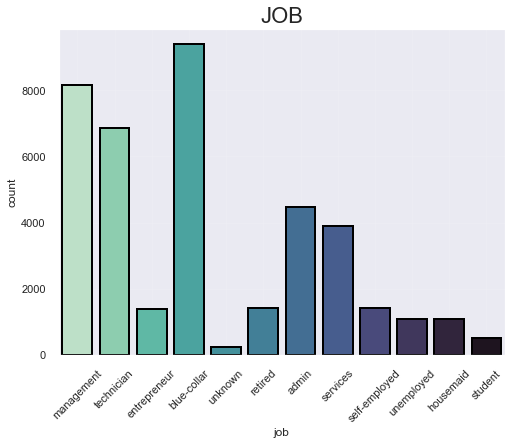

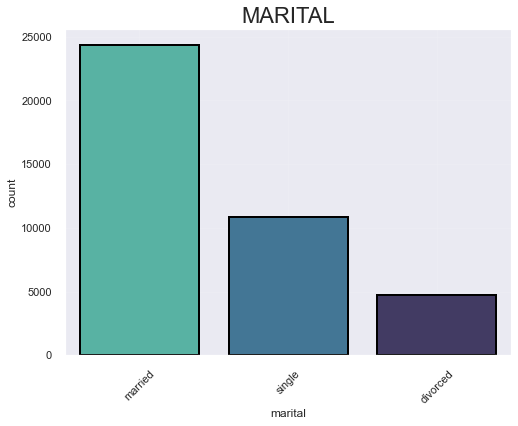

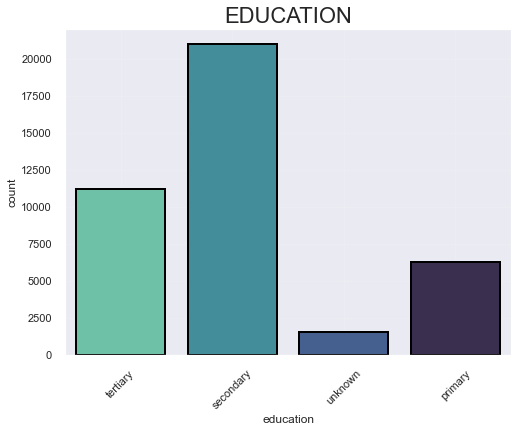

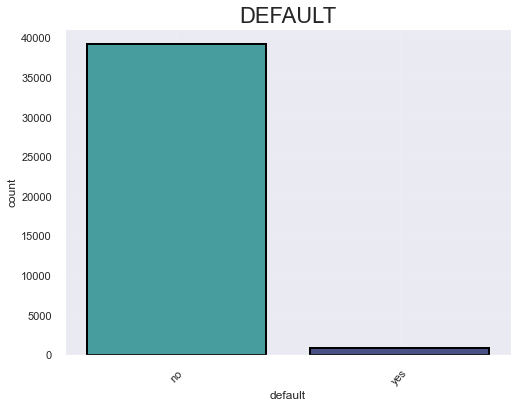

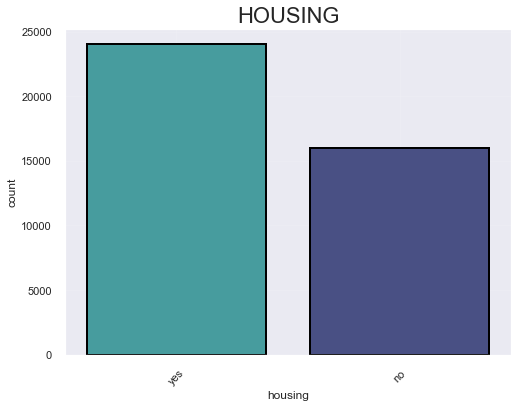

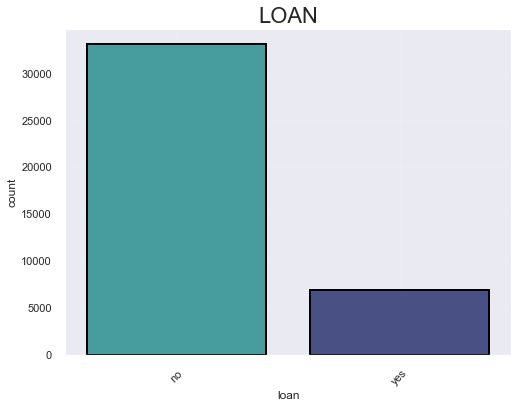

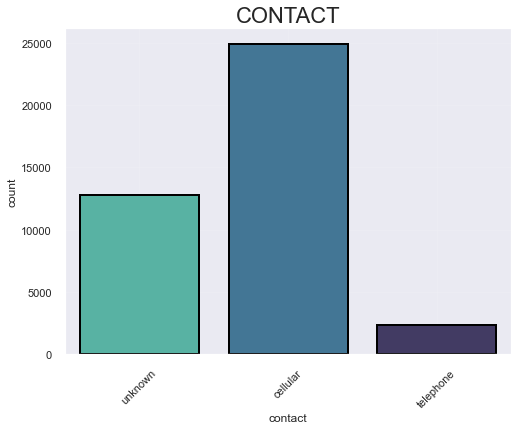

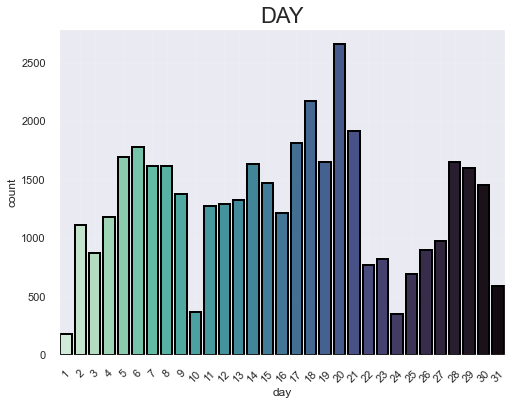

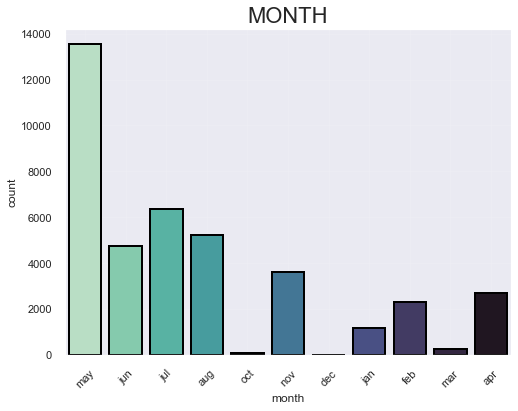

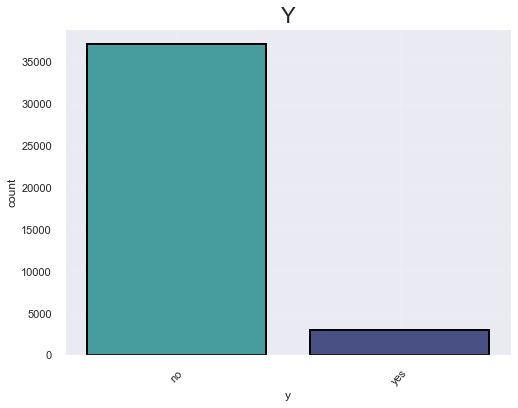

In [7]:
numerical_col = df[['age', 'balance', 'duration', 'campaign']]
for col in df.columns:
    if col not in numerical_col:
        sns.set(rc={'figure.figsize':(8,6)})
        sns.countplot(x=col, data=df,  palette='mako_r', edgecolor='black', linewidth=2) 
        plt.title(col.upper(), fontsize = 22)
        plt.grid(alpha=0.1)
        plt.xticks(rotation=45)
        plt.show()

- Most of the people work in `blue-collar`, `management` and `technician` jobs. 
- The social status of half of the people is married and the rest are divided between singles and divorced.

- The majority of people have `secondary` education or less.
- The vast majority of people do not have a default in paying the expected fees. 
- More than half of people are having a house loan, on the other hand, most people haven't a personal loan.
- As expected **most** of the communication was through `cellular` and only an insignificant percentage is through `telephone`, the rest was `unknown` and I expect that was through `emails`, `face 2 face` or any other social platform.

- The company contacts their customers or potential ones mostly in the middle of the month, as we can see from the figure the first and last 10 days of the month are similar.
- Most of the last contact happens in the **spring/summer** time like in `May`, `July`, and `August`.

- It's clear to me that more than `90%` of people didn't subscribe to a `term deposit`, which means that we have a high bias in our data.

And here I will plot the same categorical features but with hue to the target to see if anything is interesting.

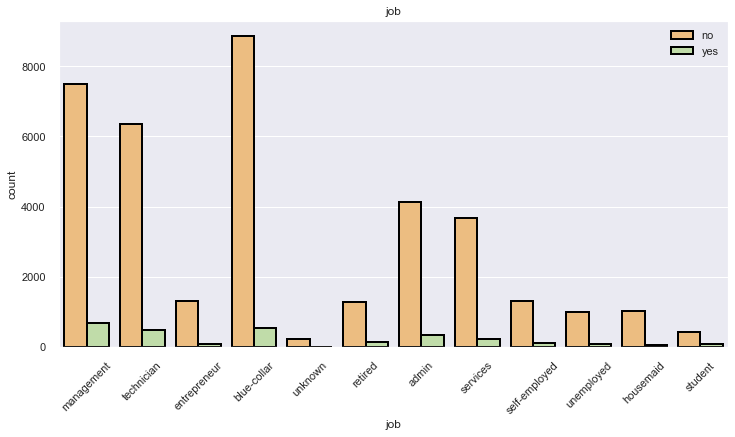

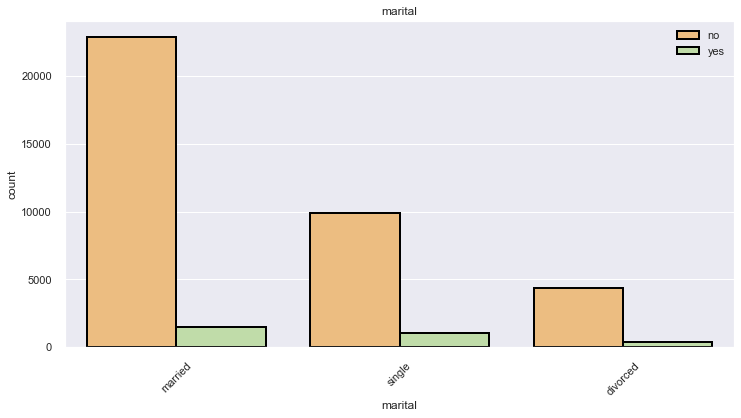

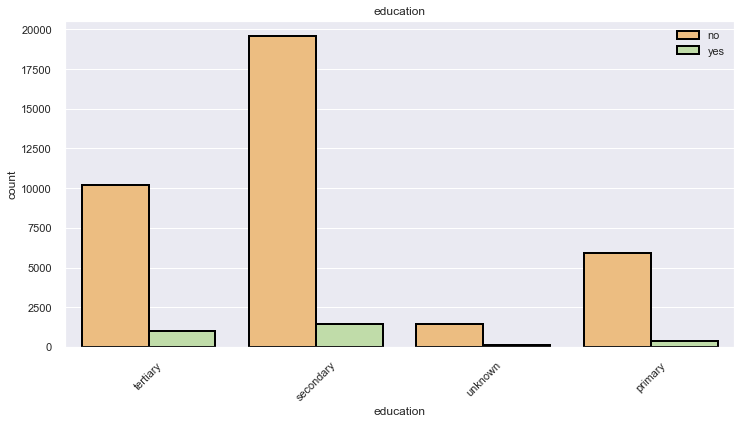

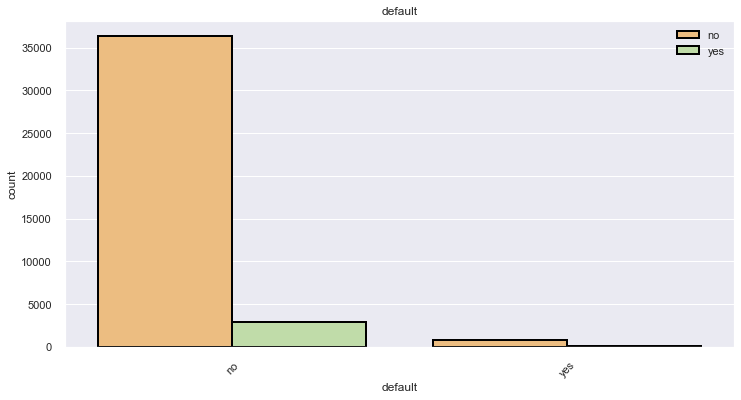

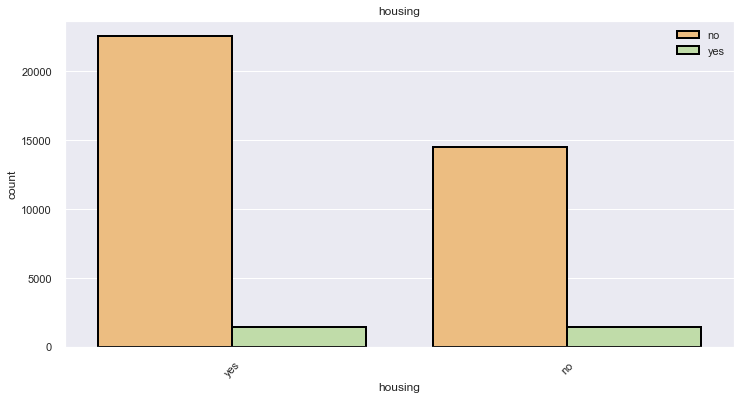

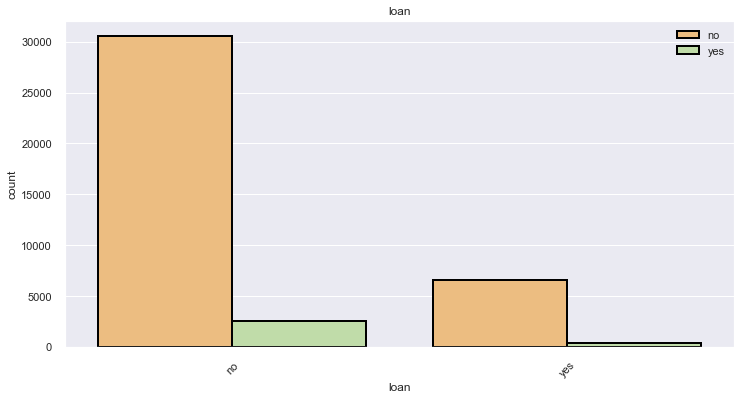

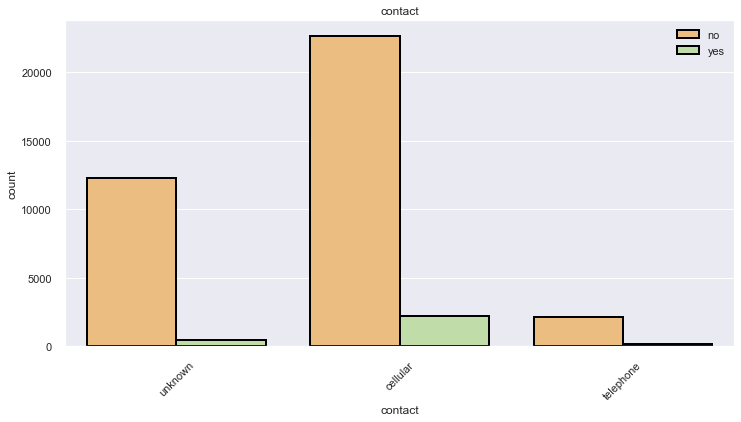

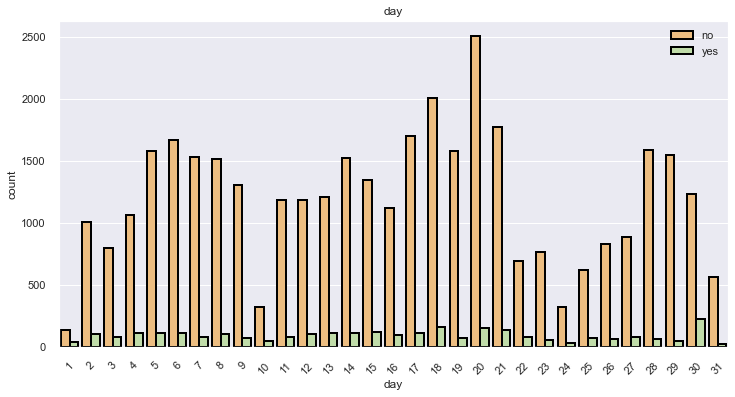

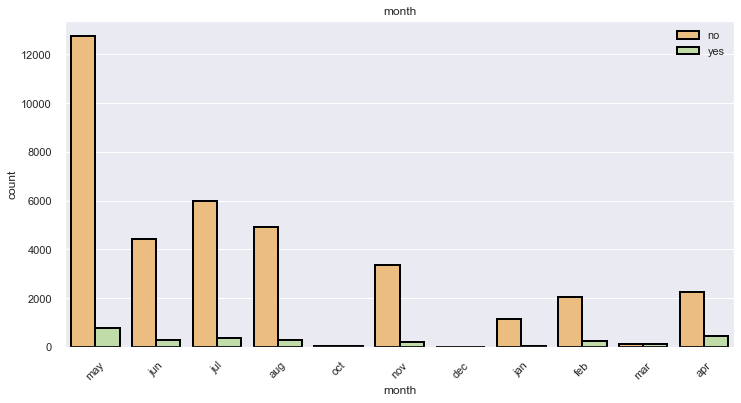

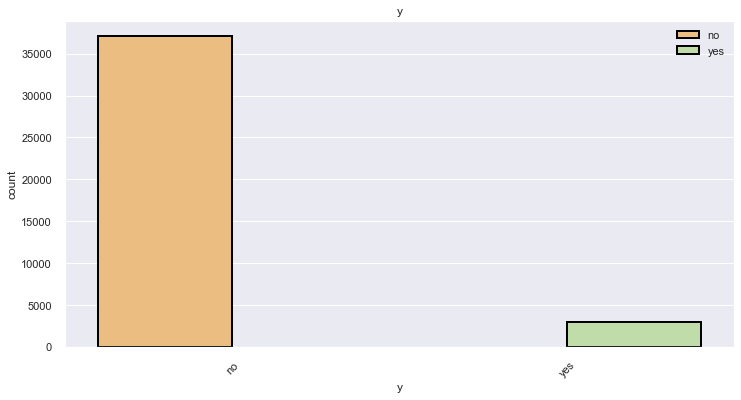

In [8]:
for column in df.columns: 
    if column not in numerical_col:
        sns.set(rc={'figure.figsize':(12,6)})
        ax = sns.countplot(df[column], hue=df.y, palette='Spectral', edgecolor='black', linewidth=2)
        plt.title(column)
        plt.xticks(rotation=45)
        plt.legend(loc = "upper right")
        plt.show()

Most of the `Subscribers` and `Non-Subscribers` came from the same professions as `blue-collar`, as well as the same social status, most of them are `married`, and most of the last contact is in `May`, so I do not see anything clear to differentiate between them so far.

Now let's see the numerical features.

In [9]:
df.describe()

,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,4.247072,2.882175
std,9.641776,2903.769716,8.278127,4.322775,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,1.666667,1.000000
50%,39.000000,407.000000,17.000000,2.916667,2.000000
75%,48.000000,1319.000000,21.000000,5.216667,3.000000
max,95.000000,102127.000000,31.000000,81.966667,63.000000


- The average age id `40` year.
- The average yearly balance is `1274` euros, and definitely there are outliers.
- The average of the duration is `4` min and also there are outliers.
- On average the company contacts the customer `3` times before the client decides to subscribe or not.

I will see the distribution of the numerical features within addition I will plot the distribution for `Subscribers/Non-Subscribers` distribution.

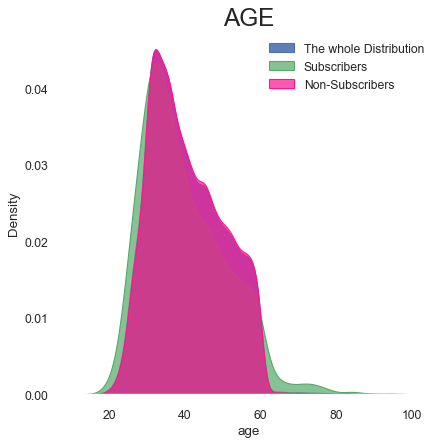

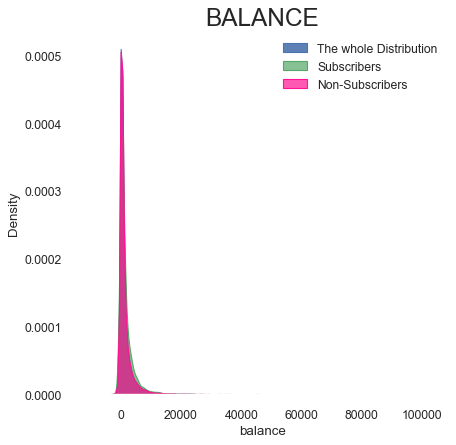

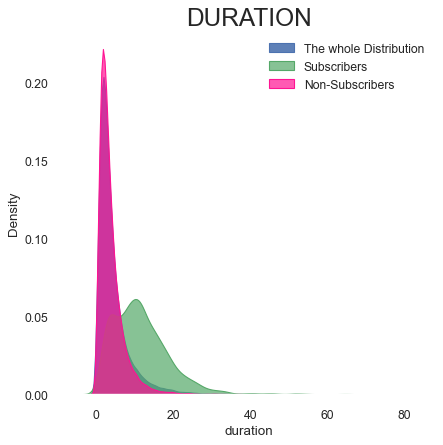

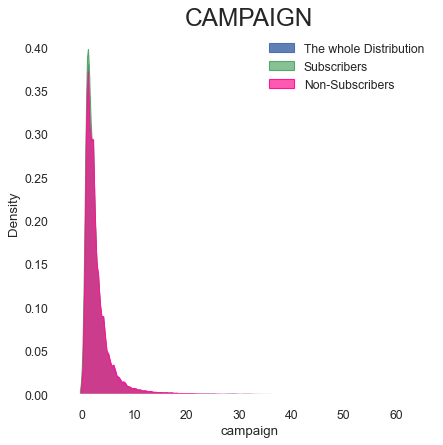

In [10]:
for col in numerical_col.columns:
    plt.figure(figsize=(6,6), dpi= 80)
    plt.rcParams['axes.facecolor'] = 'none'
    sns.kdeplot(numerical_col[col], shade=True, color="b",alpha=.9, label="The whole Distribution" )
    sns.kdeplot(df[df.y == 'yes'][col], shade=True, color="g", label="Subscribers", alpha=.7)
    sns.kdeplot(df[df.y == 'no'][col], shade=True, color="deeppink", label="Non-Subscribers", alpha=.7)
    # Decoration
    plt.title(col.upper(), fontsize=22)
    plt.legend()



    plt.show()

The distributions are quite similar for all numerical columns except the `duration` column. As it is clear the subscriber talk for a longer time than non- subscriber with the customer service which makes sense to ask for a question, .. etc.

Here I will see the outliers for all the numerical features.

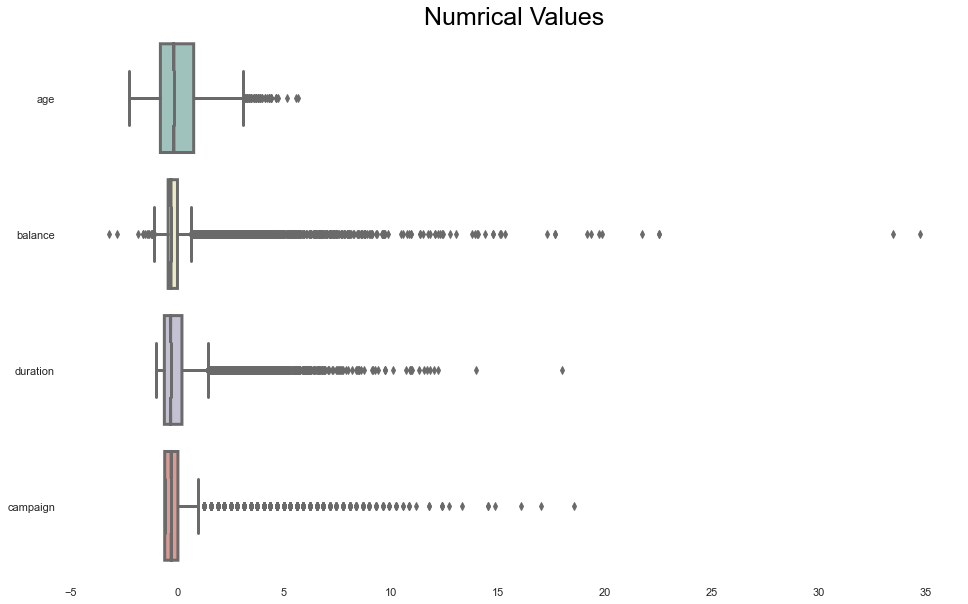

In [11]:
def var_standardized(var):
    var_stand = (var-var.mean())/var.std()
    return var_stand

numrical_value= var_standardized(numerical_col)
fig,ax=plt.subplots(figsize=(16,10))

sns.boxplot(data=numrical_value, orient='h', fliersize=5, 
                 palette="Set3", linewidth=3, notch=True, saturation=0.5, ax=ax)
plt.title('Numrical Values', fontsize = 25,color='black');

Wow! That looks like too many outliers. I will deal with them in the cleaning part.

Let's see if there is any correlation between our features.

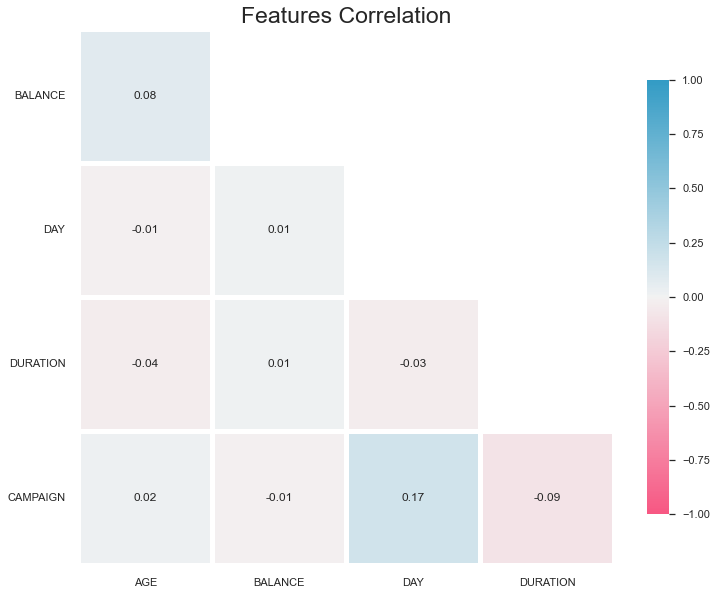

In [12]:
fig, ax = plt.subplots(figsize=(12, 10))
# get correlations
df_corr = df.corr()
# mask
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
# adjust mask and df
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()
# color map
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", 
           linewidths=5, cmap=cmap, vmin=-1, vmax=1, 
           cbar_kws={"shrink": .8}, square=True)
# ticks
yticks = [i.upper() for i in corr.index]
xticks = [i.upper() for i in corr.columns]
plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=xticks)
# title
title = 'Features Correlation'
plt.title(title, loc='center', fontsize=23)
plt.show()

It looks like there is no clear correlation between the features.

--- 
<br>


# Cleaning

Now based on the previous analysis I will start cleaning the numerical columns which are `age`, `balance`, `duration` and `campaign` by using the `Interquartile range (IQR)`.

In [13]:
Q1 = numerical_col.quantile(0.25)
Q3 = numerical_col.quantile(0.75)
IQR = Q3 - Q1
print('-' * 30)
print('min:\n', (Q1 - 1.5 * IQR))
print('-' * 30)
print('max: \n', (Q3 + 1.5 * IQR))
print('-' * 30)

------------------------------
min:
 age           10.500000
balance    -1843.500000
duration      -3.658333
campaign      -2.000000
dtype: float64
------------------------------
max: 
 age           70.500000
balance     3216.500000
duration      10.541667
campaign       6.000000
dtype: float64
------------------------------


- So for `min`: All the values inside those columns must be bigger than that number. 

- And for `max`: All the values inside those columns must be lower than that number.

Before dropping any rows I will print the data shape to see later how much we lost from the data.

In [14]:
df.shape

(40000, 14)

In [15]:
df.drop(df.loc[df['age'] >= 70].index, inplace=True)
df.drop(df.loc[(df['balance'] > 3216) | (df['balance'] < -1843)].index, inplace=True)
df.drop(df.loc[df['duration'] > 10].index, inplace=True)
df.drop(df.loc[df['campaign'] > 6].index, inplace=True)
df.shape

(30205, 14)

In [16]:
40000 - 30205, (1-(30205/40000)) * 100

(9795, 24.487499999999997)

So, the new data shape is `(30205, 14)`. Which means we lost `9795` row and that represent `~24%` of our data

Let's see if all the outliers are gone or not.

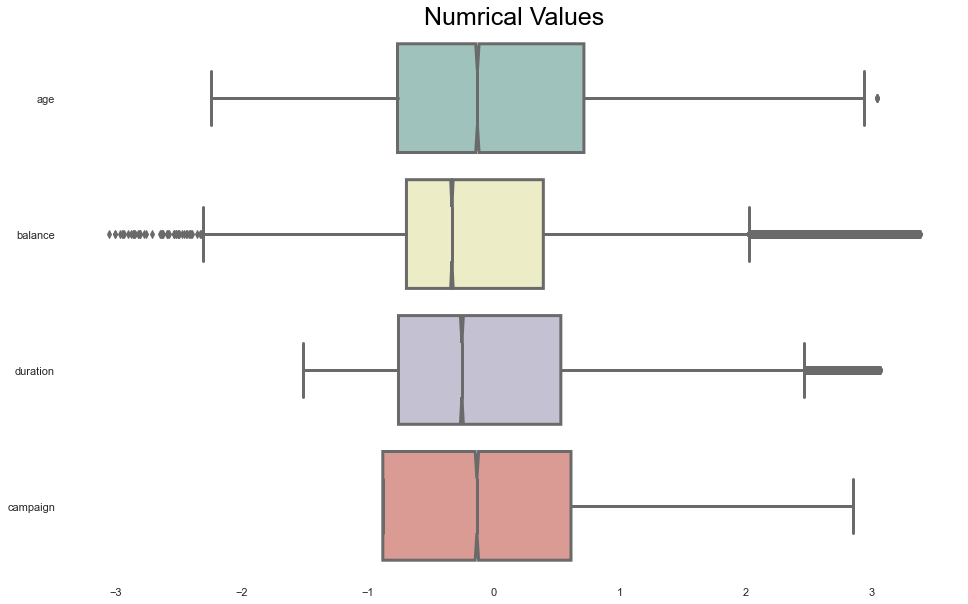

In [17]:
numerical_col = df[['age', 'balance', 'duration', 'campaign']]

numrical_value= var_standardized(numerical_col)
fig,ax=plt.subplots(figsize=(16,10))

sns.boxplot(data=numrical_value, orient='h', fliersize=5, 
                 palette="Set3", linewidth=3, notch=True, saturation=0.5, ax=ax)
plt.title('Numrical Values', fontsize = 25,color='black');


Hmm, both of the `age` and `campaign` columns have been cleaned but the `duration` and `balance` columns are not.
I can do more cleaning but this will make us loos a huge chunk of the data, so I believe this cleaning is enough.

--- 
<br>


# Modeling Preparation

I will represent the categorical features by **1** and **0**, that's why I will use `dummies`.

In [18]:
df = pd.get_dummies(df)
df.head()

,age,balance,day,duration,campaign,job_admin,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,y_no,y_yes
0,58,2143,5,4.350000,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
1,44,29,5,2.516667,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,33,2,5,1.266667,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
3,47,1506,5,1.533333,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,33,1,5,3.300000,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


I will drop the unnecessary columns like `job_unknown`.

In [19]:
df.drop(['job_unknown','education_unknown',  'default_no', 'housing_no', 'loan_no', 'contact_unknown', 'y_no']
            , axis = 1, inplace = True)

---

# Experiment With Baseline Models

As for the modeling, I will use the `Lazy Prediction` library, on the basis of which I will choose the top 4 models, and I will try to improve their scores through `Randomized Search`.

To speed up the process I will test the `Lazy Prediction` library on a random subset of the data

In [ ]:
ramdom_samples = df.sample(10000)
X = ramdom_samples.drop("y_yes", axis=1) # the Features
y = ramdom_samples["y_yes"] # the Target

# Divide the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2,random_state = random_state)
scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)


# It's stopped working due to version issues but I was able to get the output yesterday, once the problem is solved
# I will update the notebool

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

models

And now let's test the top 4 model with and without the `Randomized Search`.

In [20]:
# np.random.seed(44) # I get the same result when I run the model again.
X = df.drop("y_yes", axis=1) # the Features
y = df["y_yes"] # the Targeta
# Divide the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2,random_state = seed_value)
scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

I will use `randon_search` function to have a test the models with different values.

In [21]:
def randon_search(model, space, random_seed = seed_value):
    
    """ 
    A function takes 2 varibles:
    1.model: The model name
    2.space: Dictionary with values determined to get the best hyperparameters  
    
    """
    # define model
    model = model
    
    # define evaluation
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state= seed_value)

    # define search
    search = RandomizedSearchCV(model, space, n_iter=500, scoring='roc_auc', n_jobs=-1
                                , cv=cv, random_state= seed_value)
    
    # execute search
    result = search.fit(X_train_s, y_train)
    
    # summarize result
    print('Best Hyperparameters: %s' % result.best_params_)


<br>

## Nearest Centroid Model

Let's test the `Nearest Centroid Model` with `Randomized Search`

In [24]:
space = {'shrink_threshold' : loguniform(1e-4, 1),
        'metric' : ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
        }

randon_search(NearestCentroid(), space)

Best Hyperparameters: {'metric': 'cosine', 'shrink_threshold': 0.008787587133630375}


<br>

## Passive Aggressive Classifier Model

Let's test the `Passive Aggressive Classifier Model` with `Randomized Search`

In [26]:
space = {'C' : loguniform(1e-5, 10),
        'loss' : ['squared_hinge','hinge'],
         'fit_intercept' : [True, False],
         'shuffle' : [True, False],
         'tol' : loguniform(1e-5, 10),
         'max_iter' : loguniform(1, 1000)}

randon_search(PassiveAggressiveClassifier(random_state=seed_value), space)

Best Hyperparameters: {'C': 0.0011697373987189085, 'fit_intercept': False, 'loss': 'squared_hinge', 'max_iter': 32.270197487104035, 'shuffle': False, 'tol': 1.486741464027797e-05}


<br>

## GaussianNB Model

Let's test the `GaussianNB Model` with `Randomized Search`

In [27]:
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

randon_search(GaussianNB(), params_NB)

Best Hyperparameters: {'var_smoothing': 0.15199110829529336}


<br>

## Linear Discriminant Analysis Model

Let's test the `Linear Discriminant Analysis Model` with `Randomized Search`

In [28]:
space = {'solver' : ['svd', 'lsqr', 'eigen'],
        'shrinkage' : [None,'auto'],
         'store_covariance' : [True, False],
         'tol' : loguniform(1e-6, 1)}

randon_search(LinearDiscriminantAnalysis(), space)

Best Hyperparameters: {'shrinkage': None, 'solver': 'svd', 'store_covariance': True, 'tol': 0.15427008668812361}


---

From the previous search, I will train and evaluate the 4 different models once with random search output and the other ones without. And for this purpose, I will use the `modeling` function.

In [29]:
models = [{'label': 'Nearest Centroid', 'model': NearestCentroid()},
          {'label': 'GaussianNB', 'model': GaussianNB()}, 
          {'label': 'Passive Aggressive', 'model': PassiveAggressiveClassifier()},
          {'label': 'Linear Discriminant Analysis', 'model': LinearDiscriminantAnalysis()},
          
          
          {'label': 'Nearest Centroid (RS)', 'model': NearestCentroid(metric = 'cosine'
                                        , shrink_threshold =0.008787587133630375)},
          
          {'label': 'GaussianNB (RS)', 'model': GaussianNB(var_smoothing = 0.15199110829529336)},
          
          
          {'label': 'Passive Aggressive (RS)', 'model': PassiveAggressiveClassifier(C = 0.0011697373987189085, 
            fit_intercept = False, loss = 'squared_hinge', max_iter =32.270197487104035, 
            random_state = seed_value,shuffle = False, tol = 1.486741464027797e-05)},
          
          
          {'label': 'Linear Discriminant Analysis (RS)', 'model': LinearDiscriminantAnalysis(shrinkage = None, 
                                        solver = 'svd', store_covariance = True, tol = 0.15427008668812361)}]

In [32]:
def modeling(models, X_train, y_train, X_test, y_test):
    """
    Input: (X_train, y_train, X_test, y_test) 
    Output: ROC Curves + confusion matrixs
    
    """
    global classifiers
    classifiers = []
    class_names = ['Non-Subscribers', 'Subscribers']
    colors = ['#FF00E4', '#6F69AC', '#84DFFF', '#516BEB', '#FF9999', '#2FDD92', '#FFB085'
              , '#00A19D', '#000B49', '#FFBD35']
    i = 0
    for m in models:
        # select nd train the model
        model = m['model'] .fit(X_train, y_train)
        classifiers.append(model)
        
        # predict the test data
        y_pred=model.predict(X_test) 
        
        # Compute False postive rate, and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict(X_test))
        
        # Calculate Area under the curve to display on the plot
        auc = metrics.roc_auc_score(y_test,model.predict(X_test))
        
        # Now, plot the computed values
        plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc), color = colors[i],linewidth=2.0)
        i += 1


    # Custom settings for the plot 
    plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
    plt.title('ROC Curve', size=22)
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend(loc = "lower right");

    # Now, plot the confusion matrix
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20,20))
    for cls, ax in zip(classifiers, axes.flatten()):
        plot_confusion_matrix(cls, X_test_s, y_test, ax=ax, cmap='PuBu', display_labels=class_names
                              , xticks_rotation='vertical', colorbar = False, normalize='true')
        ax.title.set_text(type(cls).__name__)
        fig.tight_layout(pad=1)
    


    plt.show()   # Display

**NOTE:**
<p style="text-align:left
          ; color:red">The first 4 confusion matrix are without the random search result. And the last 4 are with.</p>


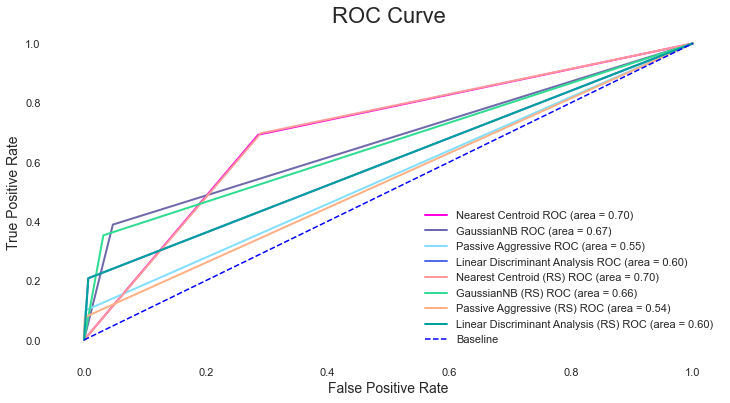

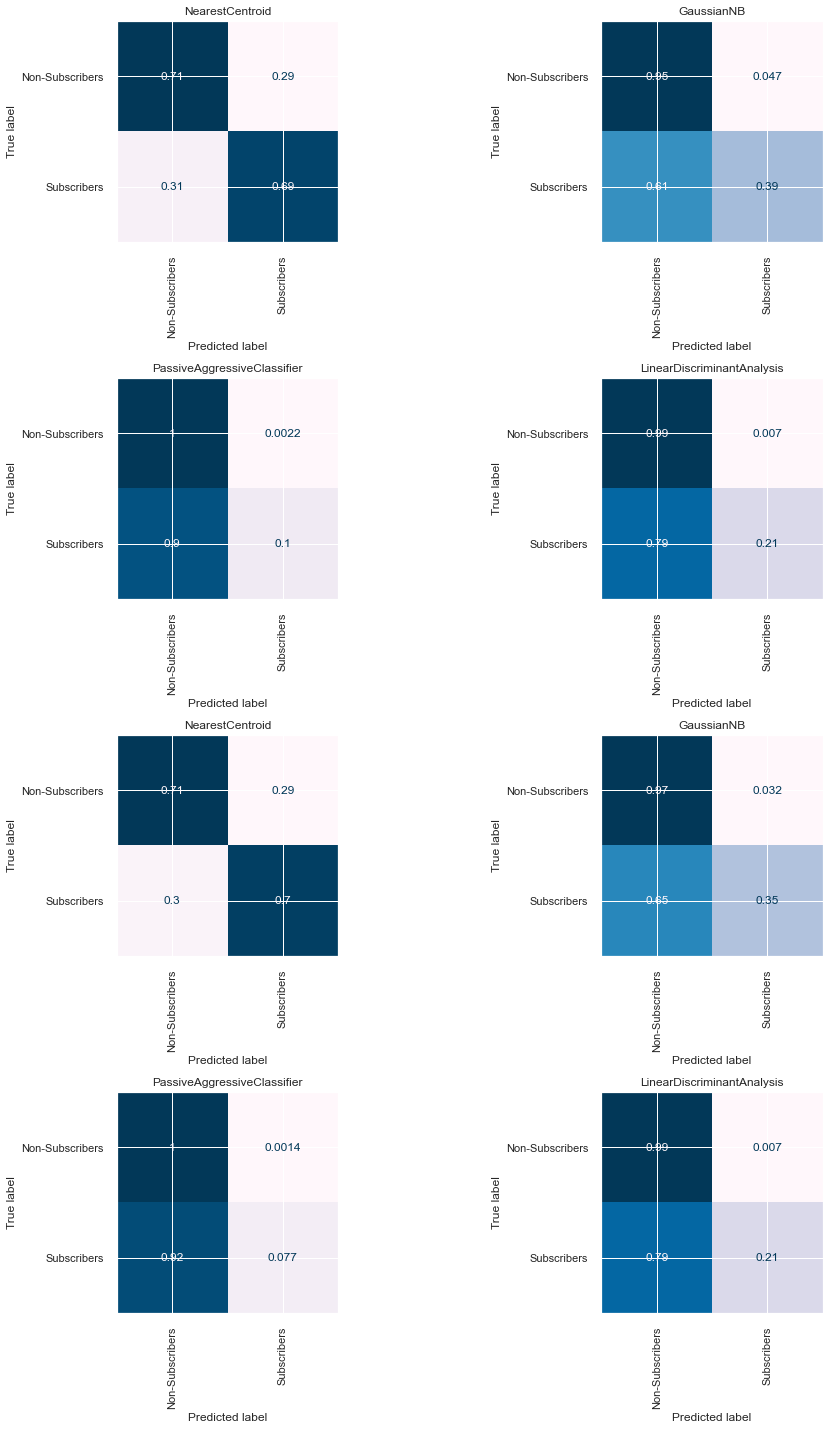

In [33]:
modeling(models, X_train_s, y_train, X_test_s, y_test)

The best model is `Nearest Centroid`, and there is no difference between the scores with or without the random search output.

---

Because there is a bias toward the `0` class which is a `non-subscribers` I will try to use **undersampling/oversampling** techniques to see if the score will improve or not.

<br>

## Undersampling Technique

In [34]:
# summarize class distribution
print(Counter(y_train))

# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')

# fit and apply the transform
X_under_sam, y_under_sam = undersample.fit_resample(X_train_s, y_train)

# summarize class distribution
print(Counter(y_under_sam))

Counter({0: 23309, 1: 855})
Counter({0: 855, 1: 855})


Now, I will train the model on `853` only insted of `23314` for **0** class.

**NOTE:**
<p style="text-align:left
          ; color:red">The first 4 confusion matrix are without the random search result. And the last 4 are with.</p>


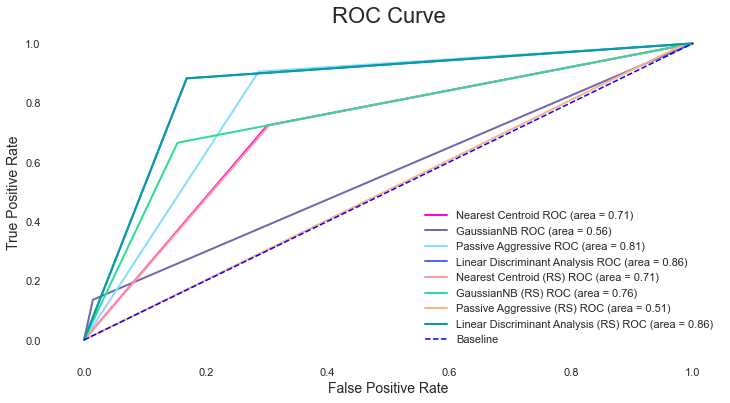

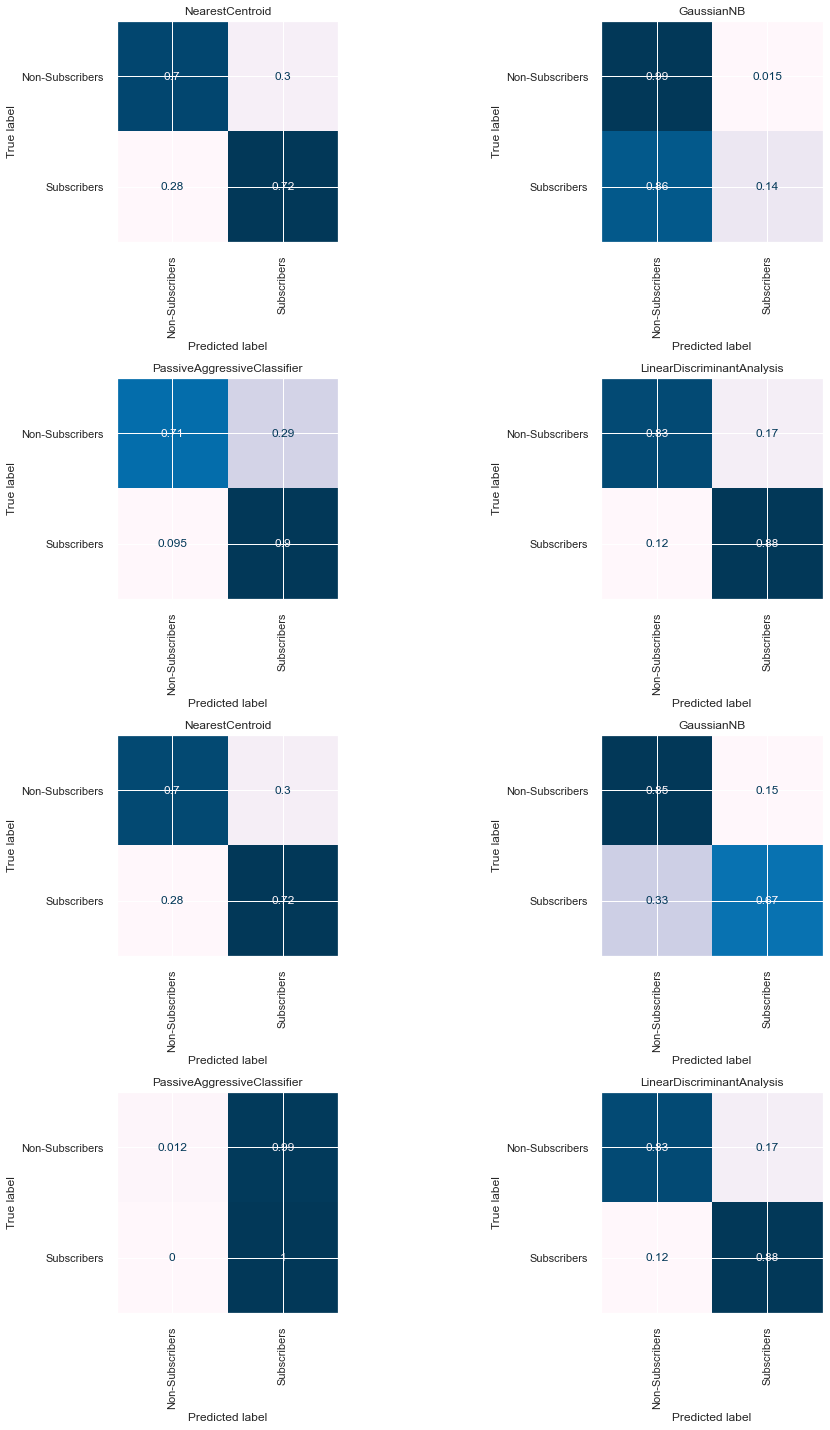

In [35]:
modeling(models, X_under_sam, y_under_sam, X_test_s, y_test)

By using **undersampling** the `LinearDiscriminantAnalysis` model has the highest performance, which is `86%`.


<br>

## Oversampling Technique

In [36]:
# summarize class distribution
print(Counter(y_train))

# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')

# fit and apply the transform
X_over_sam, y_over_sam = oversample.fit_resample(X_train_s, y_train)

# summarize class distribution
print(Counter(y_over_sam))

Counter({0: 23309, 1: 855})
Counter({0: 23309, 1: 23309})


Now, I will train the model on `23314` only insted of `853` for **1** class.

**NOTE:**
<p style="text-align:left
          ; color:red">The first 4 confusion matrix are without the random search result. And the last 4 are with.</p>


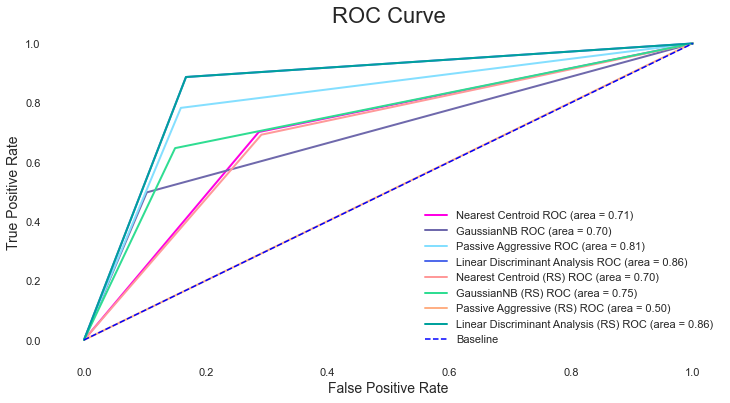

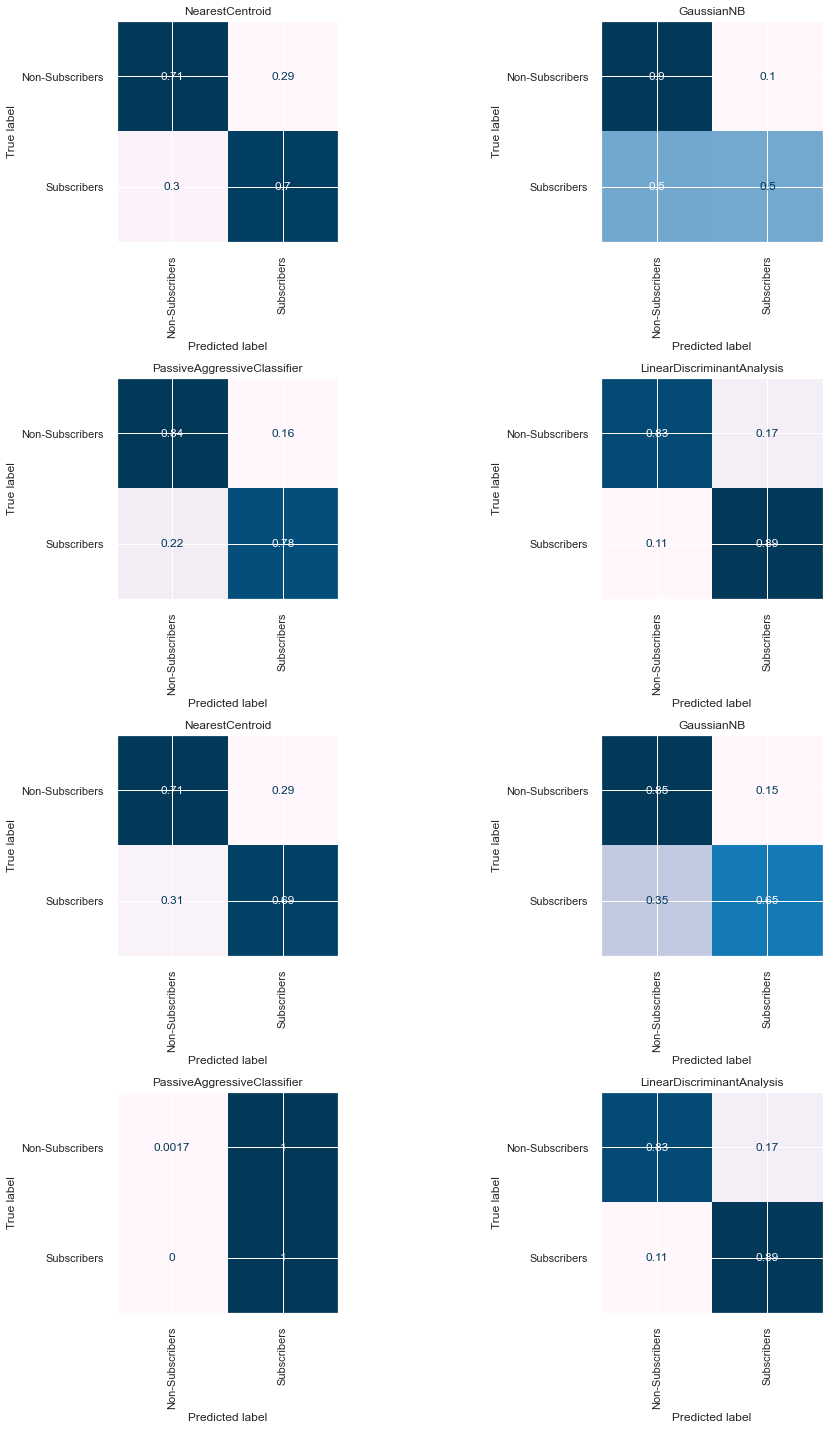

In [37]:
modeling(models, X_over_sam, y_over_sam, X_test_s, y_test)

By using **oversampling** the `LinearDiscriminantAnalysis` model still has the highest performance, which is `86%` but there is a slight change in the confusion matrix.


<br>

## MLP

I also will use the `MLP` to try to improve the score by testing multiple hyperparameters like testing the model with different optimizers, layers, ...etc.

Epoch 1/100
152/152 [==============================] - 1s 4ms/step - loss: 0.2823 - auc: 0.9649 - val_loss: 0.1748 - val_auc: 0.9578
Epoch 2/100
152/152 [==============================] - 0s 3ms/step - loss: 0.1556 - auc: 0.9692 - val_loss: 0.1627 - val_auc: 0.9702
Epoch 3/100
152/152 [==============================] - ETA: 0s - loss: 0.1468 - auc: 0.974 - 1s 3ms/step - loss: 0.1473 - auc: 0.9747 - val_loss: 0.1543 - val_auc: 0.9777
Epoch 4/100
152/152 [==============================] - 0s 3ms/step - loss: 0.1410 - auc: 0.9787 - val_loss: 0.1475 - val_auc: 0.9816
Epoch 5/100
152/152 [==============================] - 0s 3ms/step - loss: 0.1358 - auc: 0.9816 - val_loss: 0.1420 - val_auc: 0.9841
Epoch 6/100
152/152 [==============================] - 0s 3ms/step - loss: 0.1334 - auc: 0.9827 - val_loss: 0.1375 - val_auc: 0.9858
Epoch 7/100
152/152 [==============================] - 0s 3ms/step - loss: 0.1287 - auc: 0.9850 - val_loss: 0.1335 - val_auc: 0.9870
Epoch 8/100
152/152 [==========

Epoch 62/100
152/152 [==============================] - 0s 3ms/step - loss: 0.0867 - auc: 0.9949 - val_loss: 0.1097 - val_auc: 0.9921
Epoch 63/100
152/152 [==============================] - 0s 3ms/step - loss: 0.0869 - auc: 0.9949 - val_loss: 0.1091 - val_auc: 0.9922
Epoch 64/100
152/152 [==============================] - 0s 3ms/step - loss: 0.0863 - auc: 0.9948 - val_loss: 0.1083 - val_auc: 0.9925
Epoch 65/100
152/152 [==============================] - 0s 3ms/step - loss: 0.0868 - auc: 0.9949 - val_loss: 0.1087 - val_auc: 0.9923
Epoch 66/100
152/152 [==============================] - 0s 3ms/step - loss: 0.0852 - auc: 0.9952 - val_loss: 0.1085 - val_auc: 0.9925
Epoch 67/100
152/152 [==============================] - 0s 3ms/step - loss: 0.0866 - auc: 0.9948 - val_loss: 0.1093 - val_auc: 0.9922
Epoch 68/100
152/152 [==============================] - 0s 3ms/step - loss: 0.0859 - auc: 0.9950 - val_loss: 0.1083 - val_auc: 0.9925
Epoch 69/100
152/152 [==============================] - 0s 3ms

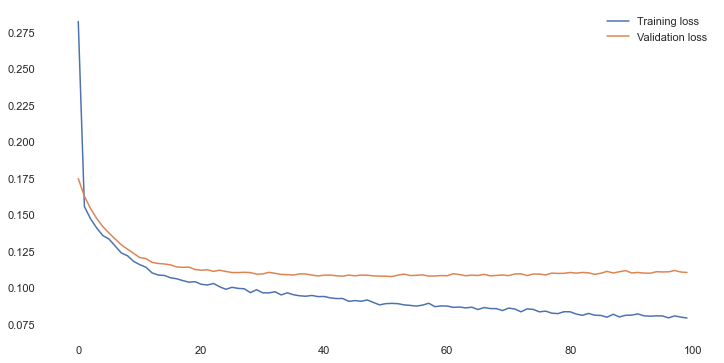

In [39]:
def build_fn(optimizer):
    model = Sequential([
        Dense(100, input_dim=38, activation="relu"),
        tf.keras.layers.Dropout(.2),
        Dense(100,activation="relu"),
        tf.keras.layers.Dropout(.2),
        Dense(50, activation="relu"),
        tf.keras.layers.Dropout(.2),

        Dense(50, activation="relu"),
        Dense(2, activation="softmax")])
    
    
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=keras.metrics.AUC(name="auc"))
    return model



# model.summary()

clf = KerasClassifier(build_fn, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
# train the model
hist = clf.fit(X_train_s, y_train, batch_size=128, epochs=100, validation_split=0.2, shuffle=True)



plt.plot(hist.history['loss'], label='Training loss')
plt.plot(hist.history['val_loss'], label='Validation loss')
plt.legend()
_ = plt.ylim()




# predict the test data
y_pred=clf.predict(X_test_s) 

# Compute False postive rate, and True positive rate
fpr, tpr, thresholds = metrics.roc_curve(y_test, clf.predict(X_test_s))

# Calculate Area under the curve to display on the plot
auc = metrics.roc_auc_score(y_test,clf.predict(X_test_s))
print('AUC score for test data', auc)

So, the best score I get is `63.6%`, therefore there is no need to see the confusion matrix for this model.

---

<br>

## Recursive Feature Elimination

To see the features importance and how they affect the model performance I will use the **Recursive Feature Elimination** method to run the model each time by eliminating one feature only.

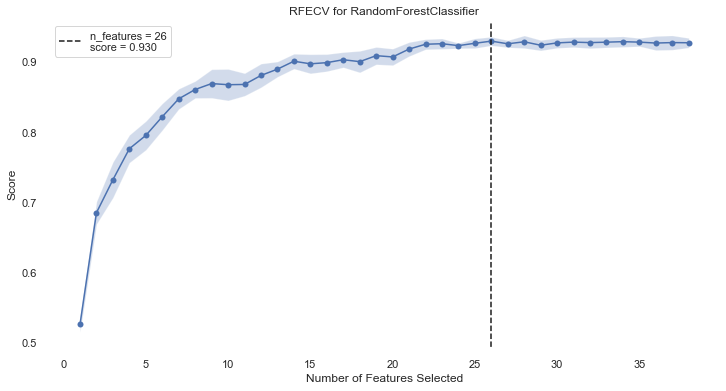

In [40]:
cv = StratifiedKFold(5)
visualizer = rfecv(RandomForestClassifier(), X=X_train_s, y=y_train, cv=cv, scoring='roc_auc')

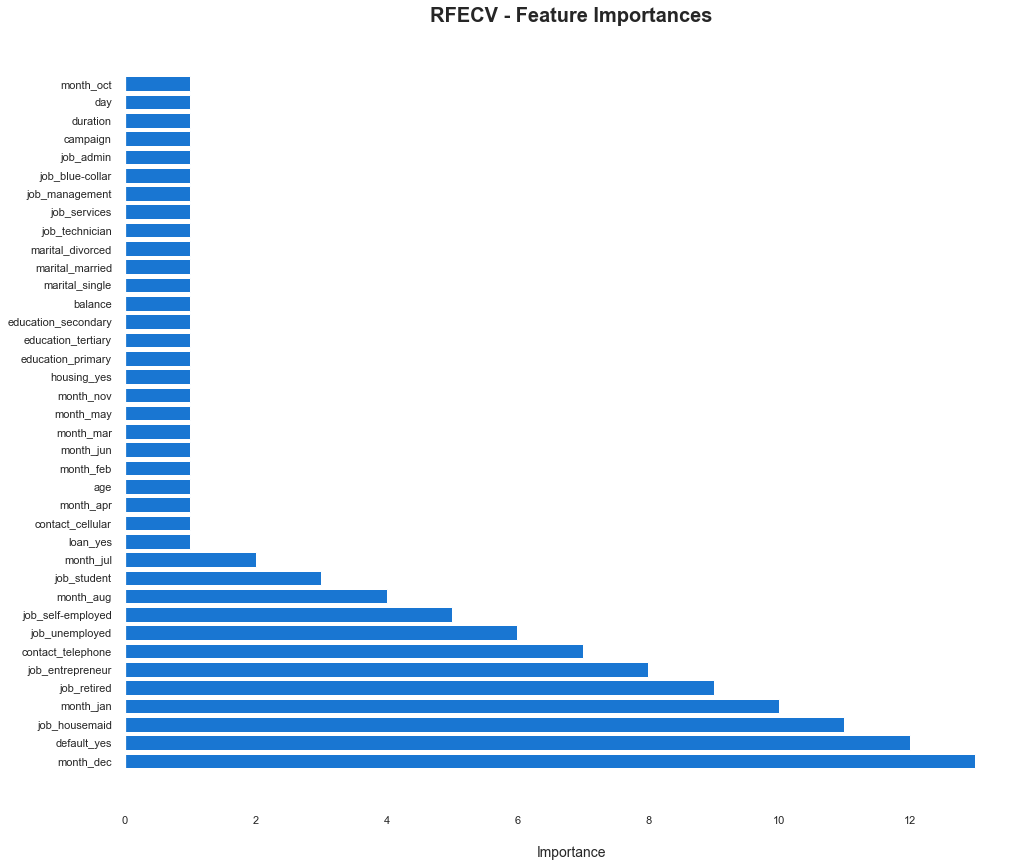

In [46]:
dset = pd.DataFrame()
dset['attr'] = X_train.columns
dset['importance'] = visualizer.ranking_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

The top 5 important indicators are if the month is `Dec, Jan`, if the client have a `default or not` and if the job is `house maid, retired` 

---

<br>

## So which model is the best?

Ok, if we are only interested in the subscribers, definitely the best model is the `Passive Aggressive` with undersampling. But if we choose that model Its will never recognize the **non-subscribers** which is make no sense!

The ideal model will distinguish between the classes with 100% of accuracy, so the best thing we can do is to choose a model performed similarly to both classes or more toward the targeted class. In our case, I think the `Linear Discriminant Analysis` model from oversampling is the better model of all the tested ones.


--- 
<br>


# Conclusion

The data has been analysed and there are no clear lines between both the classes. On the other hand, the model was able to achieve `86%` of accuracy. Moreover, the classification error rate for the nonsubscribers is `17%`, while it's lower in the subscribers class which is `11%`.

To achieve this score many models and technics are tested, some return a high score like oversampling technic and some I believe needs more time like the MLP and test other hyperparameters may return a better score. Anyway, our best model, for now, is the `Linear Discriminant Analysis`.

---